In [110]:
#uploading necessary packages and setting epochs number to 500

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import BatchNormalization
from wordcloud import WordCloud
import gensim
import re
import string
import nltk
from nltk.corpus import stopwords
#from nltk.stem import WordNetLemmatizer
#from nltk.stem.porter import *
from tqdm import tqdm
from nltk import sent_tokenize,word_tokenize
from nltk.stem import PorterStemmer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical


nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

es = EarlyStopping(monitor = "val_loss", mode = "min", patience = 5)
EPOCHS = 500

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hamej\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\hamej\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\hamej\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\hamej\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [111]:
#loading dataframe

df = pd.read_csv('all_tweets.csv', sep=",")

In [112]:
#checking it for null values 

df.isnull().sum()

Unnamed: 0    0
sentiment     0
text          0
user          0
label         0
dtype: int64

<AxesSubplot:xlabel='label'>

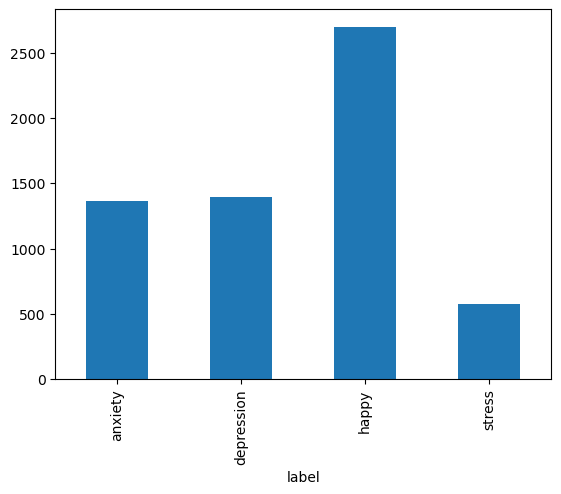

In [113]:
#plotting levels of labeled observations as bars for exploration

df.groupby(['label']).size().plot.bar()

In [114]:
#dropping unnecessary categories

df=df.drop(['Unnamed: 0', 'label', 'user'], axis=1)

positive    2974
neutral     2262
negative     796
Name: sentiment, dtype: int64

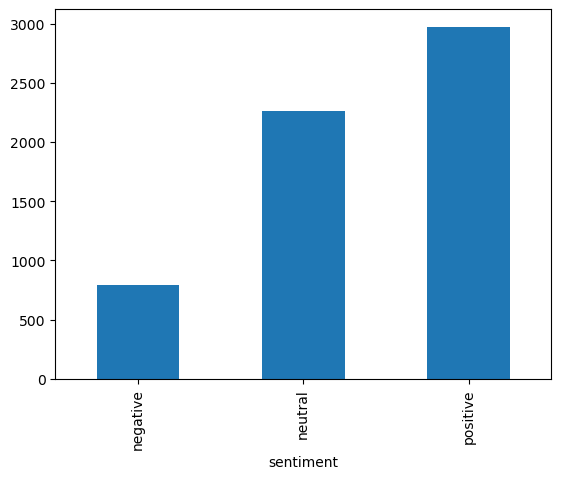

In [115]:
#plotting levels of sentiment column and checking the counts 

df.groupby(['sentiment']).size().plot.bar()
df.sentiment.value_counts()

In [116]:
#defining function for remove rt
def remove_rt(text):
    rt = re.sub(r'^RT[\s]+', '', text)
    return rt

#applying function to the column
df['text_no_rt'] = df['text'].apply(lambda x: remove_rt(x))

In [117]:
#setting lower case
df['text_lower'] = df['text_no_rt'].apply(lambda x: x.lower())

In [118]:
#defining the function to remove punctuation
def remove_punctuation(text):
    punctuationfree = "".join([i for i in text if i not in string.punctuation])
    return punctuationfree

#applying function to the column
df['no_punct'] = df['text_lower'].apply(lambda x:remove_punctuation(x))


In [119]:
#defining the function to leave only latin characters 
def latin(text):
    no_asian = re.sub(r'[^\x00-\x7f]','', text)
    return no_asian 

#applying function to the column
df['latin_only']= df['no_punct'].apply(lambda x:latin(x))

In [120]:
#defining the function to remove numbers
def numbers(text):
    no_numbers=''.join((x for x in text if not x.isdigit()))
    return no_numbers

#applying function to the column
df['no_numbers'] = df['latin_only'].apply(lambda x:numbers(x))

In [121]:
#defining the function to check for english words only 

nltk.download('words')
words = set(nltk.corpus.words.words())

def words_in_english(text):
    checking_english = " ".join(w for w in nltk.wordpunct_tokenize(text)\
                        if w.lower() in words or not w.isalpha())
    return checking_english

#applying function to the column
df['english_only'] = df['no_numbers'].apply(lambda x:words_in_english(x))




[nltk_data] Downloading package words to
[nltk_data]     C:\Users\hamej\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


In [122]:
stopwords = nltk.corpus.stopwords.words('english')

#defining the function to remove stopwords from tokenized text
def remove_stopwords(text):
    tokens = word_tokenize(text)
    output= ' '.join([i for i in tokens if i not in stopwords])
    return output


#applying the function to the column
df['no_stopwords'] = df['english_only'].apply(lambda x:remove_stopwords(x))



In [123]:
lemmatization = WordNetLemmatizer()

#defining the function to lemmatize words
def lem(text):
    tokens = nltk.word_tokenize(text)
    lema = ' '.join([lemmatization.lemmatize(w) for w in tokens])
    return lema 

#applying the function to the column
df['lemmatized']=df['no_stopwords'].apply(lambda x:lem(x))


In [124]:
ps = PorterStemmer()

#defining the function to stem words
def stem(text):
    tokens = nltk.word_tokenize(text)
    stem = ' '.join([ps.stem(w) for w in tokens])
    return stem

#applying the function to the column
df['stemmed']=df['lemmatized'].apply(lambda x:stem(x))


In [125]:
#replacing empty spaces with NaNs and dropping them 
df.replace('', np.nan, inplace=True)
df.dropna(inplace=True)
 

In [126]:
#printing df after preprocessing to show how tweets change through the process

df

,sentiment,text,text_no_rt,text_lower,no_punct,latin_only,no_numbers,english_only,no_stopwords,lemmatized,stemmed
0,positive,RT @SchudioTv: Want to know more about #autism...,@SchudioTv: Want to know more about #autism an...,@schudiotv: want to know more about #autism an...,schudiotv want to know more about autism and a...,schudiotv want to know more about autism and a...,schudiotv want to know more about autism and a...,want to know more about autism and anxiety wat...,want know autism anxiety watch short clip enrol,want know autism anxiety watch short clip enrol,want know autism anxieti watch short clip enrol
1,negative,We blame ourselves and feel worse. Start with ...,We blame ourselves and feel worse. Start with ...,we blame ourselves and feel worse. start with ...,we blame ourselves and feel worse start with s...,we blame ourselves and feel worse start with s...,we blame ourselves and feel worse start with s...,we blame ourselves and feel worse start with w...,blame feel worse start deserve,blame feel worse start deserve,blame feel wors start deserv
2,positive,"RT @PsychiatristCNS: 130,000 patient years and...","@PsychiatristCNS: 130,000 patient years and th...","@psychiatristcns: 130,000 patient years and th...",psychiatristcns 130000 patient years and the d...,psychiatristcns 130000 patient years and the d...,psychiatristcns patient years and the diagnos...,patient and the diagnostic stability of study ...,patient diagnostic stability study frequent re...,patient diagnostic stability study frequent re...,patient diagnost stabil studi frequent relat
3,neutral,RT @SkypeTherapist: See a therapist online ove...,@SkypeTherapist: See a therapist online over S...,@skypetherapist: see a therapist online over s...,skypetherapist see a therapist online over sky...,skypetherapist see a therapist online over sky...,skypetherapist see a therapist online over sky...,see a therapist over learn how to overcome anx...,see therapist learn overcome anxiety depressio...,see therapist learn overcome anxiety depressio...,see therapist learn overcom anxieti depress wi...
4,positive,"RT @PsychiatristCNS: 130,000 patient years and...","@PsychiatristCNS: 130,000 patient years and th...","@psychiatristcns: 130,000 patient years and th...",psychiatristcns 130000 patient years and the d...,psychiatristcns 130000 patient years and the d...,psychiatristcns patient years and the diagnos...,patient and the diagnostic stability of study ...,patient diagnostic stability study frequent re...,patient diagnostic stability study frequent re...,patient diagnost stabil studi frequent relat
...,...,...,...,...,...,...,...,...,...,...,...
6026,negative,RT @setiogi: 📌\n“When you said you are sad or ...,@setiogi: 📌\n“When you said you are sad or dep...,@setiogi: 📌\n“when you said you are sad or dep...,setiogi 📌n“when you said you are sad or depres...,setiogi nwhen you said you are sad or depresse...,setiogi nwhen you said you are sad or depresse...,you said you are sad or depressed please dont ...,said sad depressed please dont feel bad talk c...,said sad depressed please dont feel bad talk c...,said sad depress pleas dont feel bad talk comf...
6027,negative,"RT @EssBee_Alias: 2/3\nI noticed something,tho...","@EssBee_Alias: 2/3\nI noticed something,though...","@essbee_alias: 2/3\ni noticed something,though...",essbeealias 23ni noticed somethingthoughweach ...,essbeealias 23ni noticed somethingthoughweach ...,essbeealias ni noticed somethingthoughweach su...,ni successive to have turned more gave off d dis,ni successive turned gave dis,ni successive turned gave dis,ni success turn gave di
6028,negative,Was there a collective bad day today? Everyone...,Was there a collective bad day today? Everyone...,was there a collective bad day today? everyone...,was there a collective bad day today everyone ...,was there a collective bad day today everyone ...,was there a collective bad day today everyone ...,was there a collective bad day today everyone ...,collective bad day

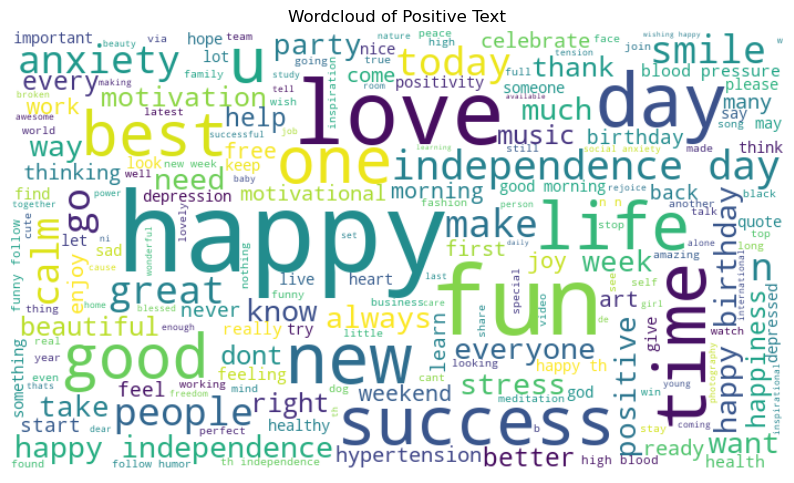

In [127]:
#creating a wordcloud from lemmatized tweets expressing positive sentiment 

positive = " ".join(df[df.sentiment == 'positive']['lemmatized'].unique())
w = WordCloud(width = 700, height = 400, random_state = 10, max_font_size = 100, background_color = 'white').generate(positive)

plt.figure(figsize = (10,6))
plt.imshow(w, interpolation = "bilinear")
plt.title("Wordcloud of Positive Text")
plt.axis('off')
plt.show()

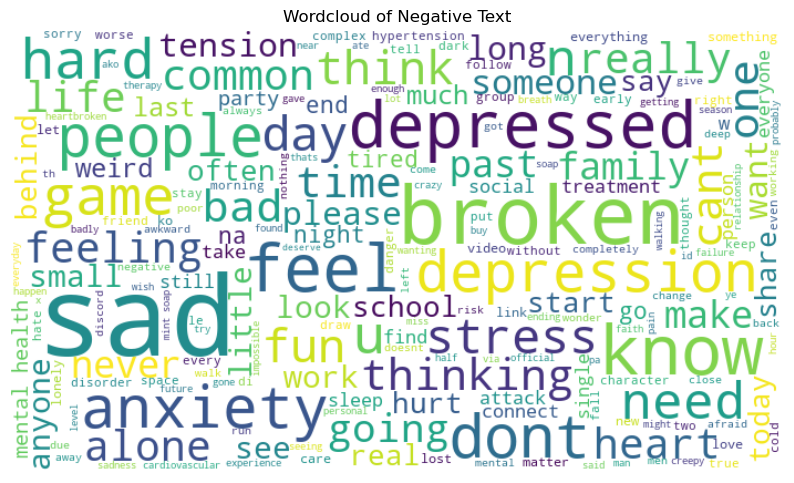

In [128]:
#creating a wordcloud from lemmatized tweets expressing negative sentiment 

negative = " ".join(df[df.sentiment == 'negative']['lemmatized'].unique())
w = WordCloud(width = 700, height = 400, random_state = 10, max_font_size = 100, background_color = 'white').generate(negative)

plt.figure(figsize = (10,6))
plt.imshow(w, interpolation = "bilinear")
plt.title("Wordcloud of Negative Text")
plt.axis('off')
plt.show()


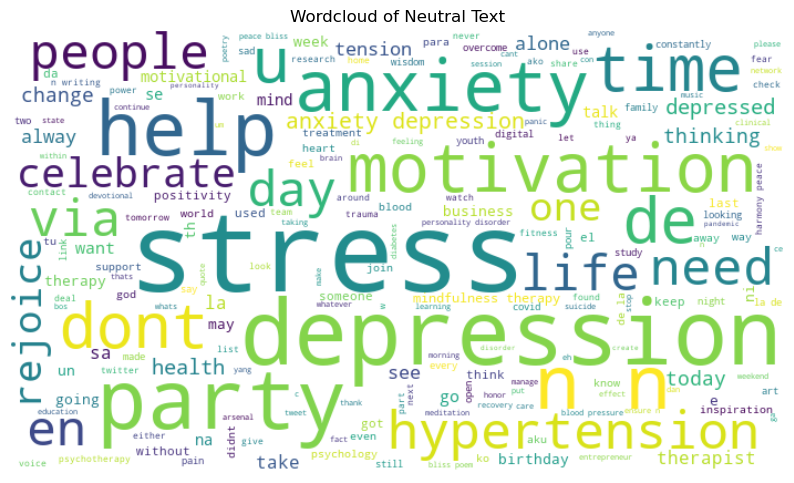

In [129]:
#creating a wordcloud from lemmatized tweets expressing neutral sentiment 

neutral = " ".join(df[df.sentiment == 'neutral']['lemmatized'].unique())
w = WordCloud(width = 700, height = 400, random_state = 10, max_font_size = 100, background_color = 'white').generate(neutral)

plt.figure(figsize = (10,6))
plt.imshow(w, interpolation = "bilinear")
plt.title("Wordcloud of Neutral Text")
plt.axis('off')
plt.show()
w.to_file('Neutral.png')


In [130]:
#playing with a pretrained model to check similarity between words 

word_list_per_sentence = [line.split(" ") for line in df["stemmed"]]

word_model = gensim.models.Word2Vec(min_count=3, sentences = word_list_per_sentence,vector_size = 20)
words = list (word_model.wv.key_to_index)

pretrained_weights = word_model.wv.vectors
vocab_size, embedding_size = pretrained_weights.shape


In [131]:
#checking similarity between a stemmed "anxieti" and other vocab in a base 

word_model.wv.most_similar("anxieti")

[('talk', 0.9926943778991699),
 ('depress', 0.9916900992393494),
 ('treatment', 0.9910943508148193),
 ('may', 0.9907519221305847),
 ('help', 0.9906989932060242),
 ('support', 0.9905351996421814),
 ('suicid', 0.9903602600097656),
 ('world', 0.9902938008308411),
 ('mental', 0.9900309443473816),
 ('see', 0.9900070428848267)]

In [132]:
#performing tokenization to prepare text for training 

tokenizer = Tokenizer(num_words = vocab_size, oov_token = "00V")
tokenizer.fit_on_texts(df['stemmed'])

In [133]:
# label_encoder = preprocessing.LabelEncoder()
# df['sentiment_cat']=label_encoder.fit_transform(df['sentiment'])

#converting sentiments names to one-hot-encoded tokens, splitting data into training and test subsets, tokenizing tweets to numbers 

y = pd.get_dummies(df.sentiment)
X_train, X_test, y_train, y_test = train_test_split(df["stemmed"], y, train_size = 0.8, random_state=1)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)
X_train_pad = pad_sequences(X_train, maxlen=10, padding="post")
X_test_pad = pad_sequences(X_test, maxlen=10, padding="post")
# y_train = to_categorical(y_train,num_classes=3)
# y_test = to_categorical(y_test,num_classes=3) 

In [134]:
#checking the effect of tokenization and convertion tokens to numbers on X train subset
X_train

[[12, 155, 509, 216, 3],
 [20, 39, 404, 13, 97, 151],
 [1, 180, 686, 279, 4],
 [1102, 616, 970, 327],
 [1, 1, 49, 1458, 70, 48, 1, 606, 139, 44],
 [10, 112, 160, 446, 54],
 [253, 275, 134, 254, 276, 366],
 [31, 60, 3, 1281, 1, 58, 110, 33, 553, 22, 750, 895],
 [54, 71, 2],
 [1, 1, 1437, 351, 1437, 985, 47],
 [51, 237, 35],
 [784, 857, 455, 574, 711],
 [39, 55, 5, 11],
 [884, 250, 65, 1, 1],
 [23, 1042],
 [32, 30, 156, 4, 27, 30, 156],
 [175, 2, 73, 27, 30, 229, 4, 2, 15],
 [35, 15, 589, 16, 105, 3, 649, 53, 8, 568],
 [219, 67, 464, 27],
 [135, 2, 411, 247, 1, 114, 247, 194],
 [24, 706],
 [1, 1, 1356, 1],
 [35, 57, 197, 1545, 9, 386, 1146, 208],
 [3, 614],
 [253, 275, 134, 254, 276, 366],
 [811, 278],
 [3, 58, 129, 11, 750, 81, 24, 49, 59],
 [122, 4],
 [1, 359, 36, 18, 10, 41, 222, 358],
 [1, 1, 1, 1372, 65],
 [9, 1, 746, 44, 442, 446, 70, 15],
 [3, 7, 7, 7],
 [51, 1, 191, 1, 1, 783],
 [506, 34, 1, 970, 1],
 [171, 108, 15, 237, 955, 28, 27, 1438],
 [85, 306, 306, 306, 1, 220, 1509],
 [4

In [135]:
#training the model to correctly classify sentiments 

from tensorflow.keras.layers import Embedding, Flatten, GRU, LSTM, SimpleRNN
model = Sequential()
model.add(Embedding(vocab_size, embedding_size, input_length=10, weights = [pretrained_weights]))
# model.add(LSTM(256))
# model.add(GRU(256, return_sequences = True))
# model.add(GRU(256))
model.add(Flatten())
# model.add(Dense(256, activation='relu'))
model.add(Dense(3, activation='softmax'))
model.summary()
model.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])
history_recur = model.fit(X_train_pad,y_train, epochs=EPOCHS, validation_data=(X_test_pad,y_test), callbacks = [es])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 10, 20)            31980     
                                                                 
 flatten_2 (Flatten)         (None, 200)               0         
                                                                 
 dense_2 (Dense)             (None, 3)                 603       
                                                                 
Total params: 32,583
Trainable params: 32,583
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
143/143 [==============================] - 1s 4ms/step - loss: 0.9493 - accuracy: 0.5328 - val_loss: 0.8751 - val_accuracy: 0.6879
Epoch 2/500
143/143 [==============================] - 0s 2ms/step - loss: 0.7746 - accuracy: 0.7293 - val_loss: 0.7116 - val_accuracy: 0.7552
Epoch 3/500
143/143 [=======

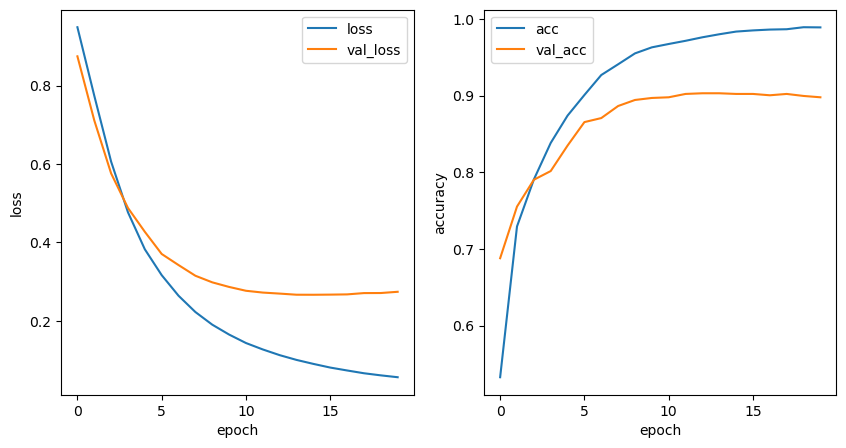

In [136]:
#plotting loss and accuracy for the yielded results

hist_recur = pd.DataFrame(history_recur.history)
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(hist_recur.loss, label = "loss")
plt.plot(hist_recur.val_loss, label = "val_loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(hist_recur.accuracy, label = "acc")
plt.plot(hist_recur.val_accuracy, label = "val_acc")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend()

plt.savefig('recur.png')